# SET DE PARAMETROS ALEATORIOS

In [1]:
# Aquí se crean N sets de parametros de posicion y orientacion para los MBHMs, los cuales serán usados más adelante para unirlos con los datos simulados.  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generar_tabla(N=30):
    tc = np.random.uniform(0, 1, N)
    phi_c = np.random.uniform(0, 2 * np.pi, N)
    psi = np.random.uniform(0, np.pi, N)                               #editado
    RA = np.random.uniform(0, 2 * np.pi, N)             
    iota = np.arccos(1 - 2 * np.random.uniform(0, 1, N))
    DEC = np.arccos(1 - 2 * np.random.uniform(0, 1, N)) - (np.pi/2)    #editado

    tabla = pd.DataFrame({
        'tc': tc,
        'phi_c': phi_c,
        'psi': psi,
        'RA': RA,
        'iota': iota,
        'DEC': DEC
    })

    return tabla

parametros = generar_tabla(30)
print(parametros)
parametros.to_csv("parametrosgeneradosN30.csv", index=False)

          tc     phi_c       psi        RA      iota       DEC
0   0.855990  4.509109  1.695647  3.340439  1.548031 -0.494367
1   0.614186  1.521721  0.914803  3.383180  1.786317  0.204423
2   0.026034  5.625404  2.369348  0.098578  1.283471  0.089975
3   0.862515  5.151009  1.316673  3.304978  0.787974 -0.950684
4   0.470372  3.031546  2.720701  5.456486  0.972083 -0.155988
5   0.113319  2.440387  1.847600  1.837238  0.229902  0.397658
6   0.207641  6.196753  0.747833  4.149798  1.817536 -0.258961
7   0.104303  1.145135  2.618137  5.029719  2.047457 -0.085259
8   0.197444  5.572649  2.463901  5.476651  0.425208 -0.153527
9   0.733508  3.210305  0.117042  0.434256  1.450041 -0.117932
10  0.837555  5.295938  2.805380  4.665532  1.949938  1.239284
11  0.863196  4.064523  1.071912  0.871762  1.091026  0.805135
12  0.626121  2.572119  2.090510  0.603792  1.669522  0.778518
13  0.621928  1.592016  1.579096  0.554903  0.604187  0.367682
14  0.170473  0.298324  2.550943  5.935337  2.596683  0

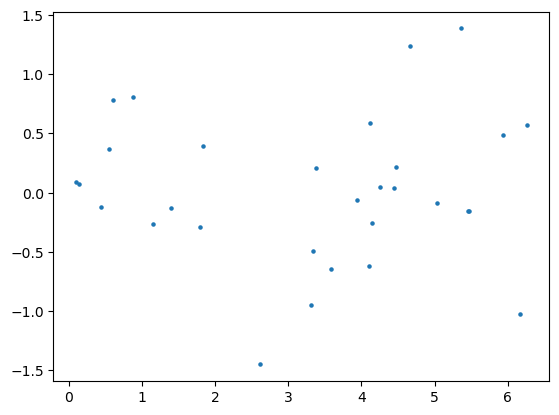

In [2]:
plt.scatter(parametros['RA'], parametros['DEC'], s=5)

# MERGER RATE

C:\Users\juanf\AppData\Local\Temp\ipykernel_3628\3053399466.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, names=column_names)
C:\Users\juanf\AppData\Local\Temp\ipykernel_3628\3053399466.py:28: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  data["dN_dt"] = simps(data["d2N_dzdt"], data["z_merger"])


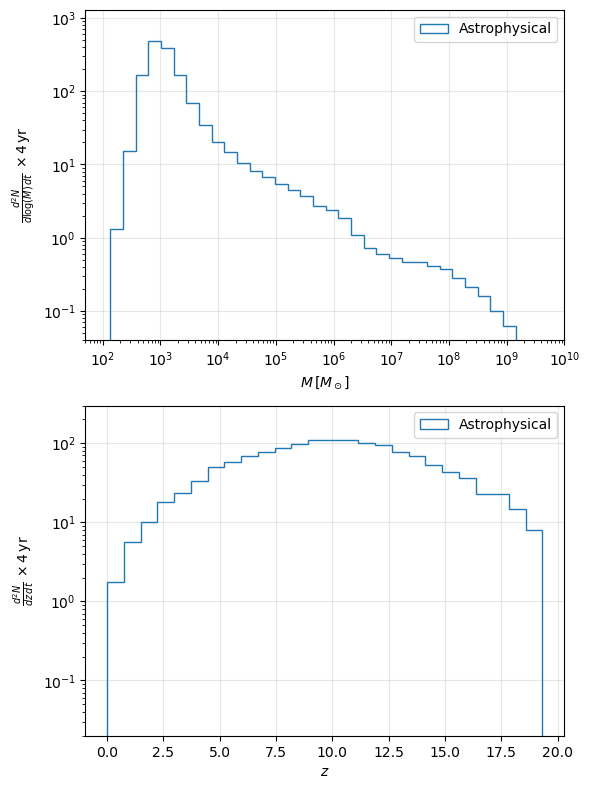

In [6]:
# Aqui se crea el merger rate usando las prescipción dada por Sadiq 2018 y los resultados de las simulaciones. Al final se ploteean el merger rate vs z y M.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from scipy import integrate
from scipy.integrate import simps


file_path = "popIII/popIII_K16_extrapolated.dat.bz2"

column_names = ["z_merger", "m1", "m2", "a1", "a2", "alpha", "beta", "gamma", "psi", "afin", "mfin", "vkick", "vesc_halo", "vesc_bar", "Mcluster", "Mdisk_stars", "Mdisk_gas", "Mbulge_stars", "Mbulge_gas", "MNSC", "Mreservoir", "Mhalo_final", "halo_density"]

data = pd.read_csv(file_path, delim_whitespace=True, names=column_names)

#c = 299792  # Velocidad de la luz en km/s
c = 9.72e-15  # Velocidad de la luz en Mpc/s
 

# ------ Se calcula la distancia luminica ------
def luminosity_distance(z):
    return cosmo.luminosity_distance(z).value  # Calcula la distancia luminica con cosmologia basada en Planck 2018 (H0 = 67.4km/s/Mpc , Ωm = 0.315, ΩΛ = 0.685)
    
data["DL"] = data["z_merger"].apply(luminosity_distance)

# ------ Luego se calcula d^2N/dzdt --------
data["d2N_dzdt"] = (4 * np.pi * c * data["halo_density"] * data["DL"]**2 / ((1 + data["z_merger"])**2))

data["dN_dt"] = simps(data["d2N_dzdt"], data["z_merger"])

# ------ Se ordenann los datos para crear los histogramas para las distribuciones ---------
# Histograma de redshift
z_bins = np.linspace(data["z_merger"].min(), data["z_merger"].max(), 27)
#z_hist, z_edges = np.histogram(data["z_merger"], bins=z_bins, weights=data["d2N_dzdt"])

# Histograma de masa total
data["total_mass"] = data["m1"] + data["m2"]
mass_bins = np.logspace(np.log10(data["total_mass"].min()), np.log10(data["total_mass"].max()), 40)
mass_hist, mass_edges = np.histogram(data["total_mass"], bins=mass_bins, weights=data["d2N_dzdt"])


#----- Aplicar gaussiana en z ------
sigma_z = 0.55 
data["z_merger_noisy"] = data["z_merger"] + np.random.normal(0, sigma_z, len(data))

z_hist, z_edges = np.histogram(data["z_merger_noisy"], bins=z_bins, weights=data["d2N_dzdt"])

# ------ Graficar ------
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=False)

axs[0].hist(
    0.5 * (mass_edges[:-1] + mass_edges[1:]), 
    bins=mass_bins,
    weights=mass_hist *3600* 24 * 365 *4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$M \, [M_\odot]$")
axs[0].set_ylabel(r"$\frac{d^2N}{d\log(M) \, dt} \, \times 4 \, \text{yr}$")
#axs[0].set_title("Differential merger rate by mass")
axs[0].grid(alpha=0.3)
axs[0].set_ylim(4e-2, 1300)
axs[0].set_xlim(50, 1e10)
axs[0].legend()

axs[1].hist(
    0.5 * (z_edges[:-1] + z_edges[1:]),  
    bins=z_bins,
    weights=z_hist *3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$z$")
axs[1].set_ylabel(r"$\frac{d^2N}{dz \, dt} \, \times 4 \, \text{yr}$")
#axs[1].set_title("Differential merger rate by redshift")
axs[1].grid(alpha=0.3)
axs[1].set_ylim(0.02, 300)
axs[1].legend()

plt.tight_layout()
plt.show()


In [51]:
# Numero total de eventos esperados en una mision de 4 años segun la simulación

total_events = np.sum(z_hist)
print(total_events * 31558149.8 * 4)

1406.1942756756118


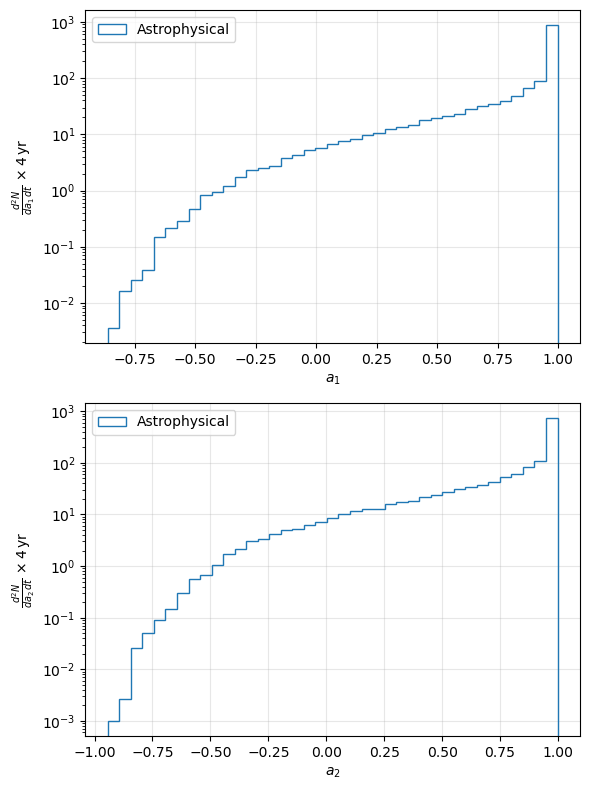

In [10]:
# Mismo merger rate que el anterior pero ahora vs a1 y a2

a1_bins = np.linspace(data["a1"].min(), data["a1"].max(), 40)
a1_hist, a1_edges = np.histogram(data["a1"], bins=a1_bins, weights=data["d2N_dzdt"])

a2_bins = np.linspace(data["a2"].min(), data["a2"].max(), 40)
a2_hist, a2_edges = np.histogram(data["a2"], bins=a2_bins, weights=data["d2N_dzdt"])

# ------ Graficar ------
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=False)

axs[0].hist(
    0.5 * (a1_edges[:-1] + a1_edges[1:]), 
    bins=a1_bins,
    weights=a1_hist*3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
#axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$a_1$")
axs[0].set_ylabel(r"$\frac{d^2N}{da_1 \, dt} \, \times 4 \, \text{yr}$")
#axs[0].set_title(r"Differential merger rate by spin parameter $a_1$")
axs[0].grid(alpha=0.3)
axs[0].legend()

axs[1].hist(
    0.5 * (a2_edges[:-1] + a2_edges[1:]),  
    bins=a2_bins,
    weights=a2_hist*3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$a_2$")
axs[1].set_ylabel(r"$\frac{d^2N}{da_2 \, dt} \, \times 4 \, \text{yr}$")
#axs[1].set_title(r"Differential merger rate by spin parameter $a_2$")
axs[1].grid(alpha=0.3)
#axs[1].set_ylim(0.003, 1000)
axs[1].legend()

plt.tight_layout()
plt.show()


# CATALOGO DE EVENTOS 

In [49]:
# Esta celda crea el catalogo de eventos esperados en un año haciendo un sampleo usando como peso el merger rate calculado anteriormente

import pandas as pd
import numpy as np

time_factor = 31558149.8                                       # Pensado para un año (Año sideral en segundos)

data["event_probability"] = data["d2N_dzdt"] * time_factor

probabilities = data["event_probability"] / data["event_probability"].sum()  # Normalizar las probabilidades

expected_events = int(data["event_probability"].sum())

print(f"Eventos esperados en 1 año: {expected_events}")

sampled_events = data.sample(n=expected_events, weights=probabilities, replace=True)
selected_columns = ["m1", "m2", "a1", "a2","DL", "z_merger", "alpha", "beta", "gamma", "halo_density","d2N_dzdt"]  # Esto filtra dejando solo las columnas de interes 
sampled_events = sampled_events[selected_columns]

mask = sampled_events['m1'] < sampled_events['m2']                          # Esta parte reordena algunas columnas de manera que siempre se cumpla que m1>m2
sampled_events.loc[mask, ['m1', 'm2']] = sampled_events.loc[mask, ['m2', 'm1']].values
assert (sampled_events['m1'] >= sampled_events['m2']).all(), "Todavía hay casos donde m2 > m1"

sampled_events.to_csv("popIII/popIII_catalog.csv", index=False)

Eventos esperados en 1 año: 352


In [43]:
data["event_probability"].sum()    # Cantidad de eventos esperados en un año, debe coincidir con el largo de la tabla 

352.50771888876193

In [45]:
# Esta celda agarra el catalogo de eventos generado y le incorpora los parametros simulados de posicion y orientacion, 
# haciendo que cada evento de repita N veces con distintos set de parametros 
 
parametros = pd.read_csv("parametrosgeneradosN100.csv")

n_eventos = len(sampled_events)

sampled_events_expanded = pd.DataFrame(np.repeat(sampled_events.values, 100, axis=0), columns=sampled_events.columns)
parametros_expanded = pd.concat([parametros] * n_eventos, ignore_index=True)

if len(sampled_events_expanded) == len(parametros_expanded):
    final_catalog = pd.concat([sampled_events_expanded.reset_index(drop=True), parametros_expanded], axis=1)
    
    final_catalog.to_csv("popIII/popIII_finalcatalog100.csv", index=False)
    print(" Catálogo final generado: popIII_finalcatalog100.csv")
else:
    print(f" Error: Tamaños desiguales - Eventos: {len(sampled_events_expanded)}, Parámetros: {len(parametros_expanded)}")


 Catálogo final generado: popIII_finalcatalog100.csv


In [47]:
# Esto divide el catalogo creado en 4 partes para poder correr las tablas

df = pd.read_csv("popIII/popIII_finalcatalog100.csv")  

df_splits = np.array_split(df, 4)

for i, df_part in enumerate(df_splits):
    df_part.to_csv(f"popIII/popIII_finalcatalogN100_{i+1}.csv", index=False)

C:\Users\juanf\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### En este punto los catalgos son llevados a Colab para usar el paquete BBHx y calcular el SNR de cada evento.

In [55]:
#Esta celda filtra los eventos con SNR >10 y los clasifica como detectables, luego calcula un average detectability para cada evento simulado.

df = pd.read_csv('popIII/popIII_snrcatalogN100_1.csv')

df['Detectable'] = df['SNR'] > 10

group_cols = ['m1', 'm2', 'a1', 'a2', 'z_merger']
detectability = df.groupby(group_cols)['Detectable'].mean().reset_index()
detectability.rename(columns={'Detectable': 'Average_Detectability'}, inplace=True)

df = df.merge(detectability, on=group_cols, how='left')

df.to_csv("popIII/popIII_finalcatalog_detectability100_1.csv", index=False)

In [59]:
# Esto agarra el catalogo con los SNR ya calculados (y el average detectability para cada evento) y devulve un catalago con el numero incial de eventos,
# osea elimina las columnas con los parametros de posicion y orientacion.

file_path = "popIII/popIII_finalcatalog_detectability100_1.csv"
df = pd.read_csv(file_path)

columns_to_drop = ['tc', 'RA', 'DEC', 'phi_c', 'iota', 'psi']

df_filtered = df.drop(columns=columns_to_drop)

df_unique = df_filtered.drop_duplicates(subset=['z_merger', 'm1', 'm2', 'a1', 'a2','DL', 'alpha', 'beta', 'gamma'])

output_path = "popIII/popIII_finalcatalog_unique_1.csv"
df_unique.to_csv(output_path, index=False)

print(f"Dimensiones finales: {df_unique.shape}")

Dimensiones finales: (88, 14)


# MERGER RATE DE EVENTOS DETECTADOS

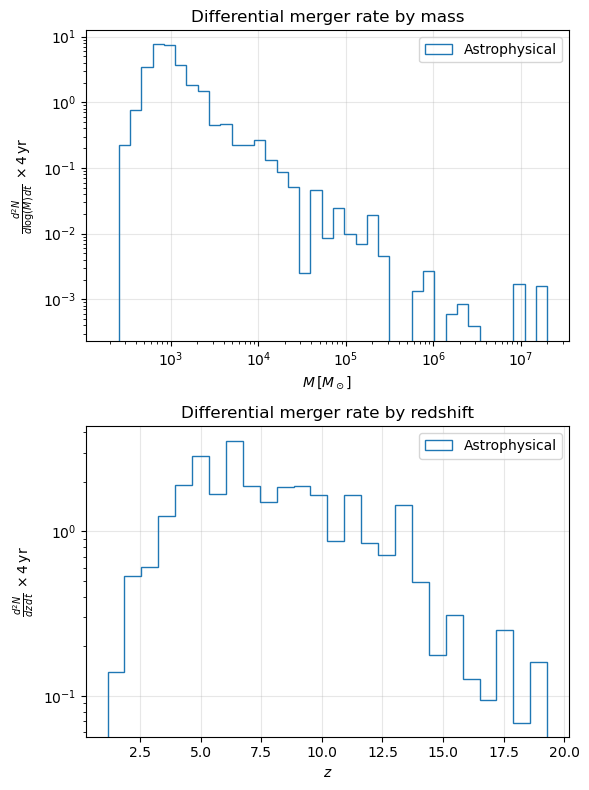

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from scipy import integrate
from scipy.integrate import simps


file_path = "popIII/popIII_catalog.csv"

#column_names = ["z_merger", "m1", "m2", "a1", "a2", "alpha", "beta", "gamma", "halo_density"]

data = pd.read_csv(file_path)

#c = 299792  # Velocidad de la luz en km/s
c = 9.72e-15  # Velocidad de la luz en Mpc/s
 

# ------ Se calcula la distancia luminica ------
#def luminosity_distance(z):
#    return cosmo.luminosity_distance(z).value  # Calcula la distancia luminica con cosmologia basada en Planck 2018 (H0 = 67.4km/s/Mpc , Ωm = 0.315, ΩΛ = 0.685)
    
#data["DL"] = data["z_merger"].apply(luminosity_distance)

# ------ Luego se calcula d^2N/dzdt --------
#data["d2N_dzdt"] = (4 * np.pi * c * data["halo_density"] * data["DL"]**2 / ((1 + data["z_merger"])**2))

#data["dN_dt"] = simps(data["d2N_dzdt"], data["z_merger"])

# ------ Se ordenann los datos para crear los histogramas para las distribuciones ---------
# Histograma de redshift
z_bins = np.linspace(data["z_merger"].min(), data["z_merger"].max(), 27)
#z_hist, z_edges = np.histogram(data["z_merger"], bins=z_bins, weights=data["d2N_dzdt"])

# Histograma de masa total
data["total_mass"] = data["m1"] + data["m2"]
mass_bins = np.logspace(np.log10(data["total_mass"].min()), np.log10(data["total_mass"].max()), 40)
mass_hist, mass_edges = np.histogram(data["total_mass"], bins=mass_bins, weights=data["d2N_dzdt"])


#----- Aplicar gaussiana en z ------
sigma_z = 0.55 
data["z_merger_noisy"] = data["z_merger"] + np.random.normal(0, sigma_z, len(data))

z_hist, z_edges = np.histogram(data["z_merger_noisy"], bins=z_bins, weights=data["d2N_dzdt"])

# ------ Graficar ------
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=False)

axs[0].hist(
    0.5 * (mass_edges[:-1] + mass_edges[1:]), 
    bins=mass_bins,
    weights=mass_hist *3600* 24 * 365 *4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$M \, [M_\odot]$")
axs[0].set_ylabel(r"$\frac{d^2N}{d\log(M) \, dt} \, \times 4 \, \text{yr}$")
axs[0].set_title("Differential merger rate by mass")
axs[0].grid(alpha=0.3)
#axs[0].set_ylim(4e-2, 1300)
#axs[0].set_xlim(100, 12e8)
axs[0].legend()

axs[1].hist(
    0.5 * (z_edges[:-1] + z_edges[1:]),  
    bins=z_bins,
    weights=z_hist *3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$z$")
axs[1].set_ylabel(r"$\frac{d^2N}{dz \, dt} \, \times 4 \, \text{yr}$")
axs[1].set_title("Differential merger rate by redshift")
axs[1].grid(alpha=0.3)
#axs[1].set_ylim(0.02, 300)
axs[1].legend()

plt.tight_layout()
plt.show()
